### Data Initilization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Z-Score Model

In [2]:
df_z=pd.read_csv('data.csv')

In [3]:
df_z.shape

(6819, 96)

In [4]:
def zscore_test(df):
    data_np=df.to_numpy()
    X=data_np[:,1:]
    y=data_np[:,0]
    zscore=[' Working Capital to Total Assets',' Retained Earnings to Total Assets',
            ' ROA(C) before interest and depreciation before interest',' Equity to Liability',' Total Asset Turnover']
    testx=df[zscore].to_numpy()
    beta=np.array([1.2,1.4,3.3,0.6,1.0])
    z=testx@beta
    for i in range(len(z)):
        if z[i]<1.8:
            z[i]=1
        else:
            z[i]=0
    print(metrics.classification_report(y, z))
    print('-----------------------------')
    print(metrics.confusion_matrix(y,z))

In [5]:
zscore_test(df_z)

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      6599
         1.0       0.00      0.00      0.00       220

    accuracy                           0.97      6819
   macro avg       0.48      0.50      0.49      6819
weighted avg       0.94      0.97      0.95      6819

-----------------------------
[[6598    1]
 [ 220    0]]


### Data Initiation

In [6]:
def removecolinear(D):
    corr_matrix = D.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
    D.drop(to_drop, axis=1, inplace=True)
    return D

In [7]:
df=pd.read_csv('data.csv')
df=removecolinear(df)
data_np=df.to_numpy()
var=df.columns
var=var.to_numpy()
var=var[1:]
print('variables#  =',len(var))

variables#  = 61


In [8]:
X=data_np[:,1:]
y=data_np[:,0]

In [9]:
from sklearn.preprocessing import StandardScaler
np.random.seed(123)
X=data_np[:,1:]
y=data_np[:,0]
scaler = StandardScaler().fit(X)
X=scaler.transform(X)
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2,stratify=y,random_state=123)

In [47]:
len(y_test[y_test==1])

44

In [10]:
def evaluation(true,predict):
    print(metrics.classification_report(true, predict))
    print('-----------------------------------------------------')

### Classifier Test

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [12]:
def classification(X_train, X_test, y_train, y_test):
    classifiers=[MLPClassifier(activation='logistic',max_iter=1000),KNeighborsClassifier(n_neighbors=5),
             GaussianProcessClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),
             GaussianNB(),LogisticRegression(solver='newton-cg',max_iter=1000),SVC(kernel='rbf'),SVC(kernel='linear')]
    names=['MLP','KNN','GPC','CART','Random Forest','Naive Bays','Logit Model','SVM','kernel SVM']
    np.random.seed(123)
    for i,clf in enumerate(classifiers):
        clf.fit(X_train,y_train)
        pred=clf.predict(X_test)
        print('Model=',names[i])
        evaluation(y_test,pred)

In [13]:
classification(X_train, X_test, y_train, y_test)

Model= MLP
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1320
         1.0       0.57      0.27      0.37        44

    accuracy                           0.97      1364
   macro avg       0.77      0.63      0.68      1364
weighted avg       0.96      0.97      0.96      1364

-----------------------------------------------------
Model= KNN
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99      1320
         1.0       0.90      0.20      0.33        44

    accuracy                           0.97      1364
   macro avg       0.94      0.60      0.66      1364
weighted avg       0.97      0.97      0.97      1364

-----------------------------------------------------
Model= GPC
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1320
         1.0       0.30      0.14      0.19        44

    accuracy                           0.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model= kernel SVM
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1320
         1.0       1.00      0.02      0.04        44

    accuracy                           0.97      1364
   macro avg       0.98      0.51      0.51      1364
weighted avg       0.97      0.97      0.95      1364

-----------------------------------------------------


### Lasso Analysis (Feature Selection)

In [14]:
# Import Lasso classifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import f1_score

In [15]:
def threshold(Z,threshold):
    for i in range(len(Z)):
        if Z[i]>=threshold:
            Z[i]=1
        else:
            Z[i]=0
    return Z

In [18]:
def lasso_model(X_train, X_test, y_train, y_test):
    alphas=np.linspace(0.001,0.1,100)
    cv=KFold(n_splits=10,shuffle=True,random_state=123)
    scores=[cross_val_score(Lasso(alpha=k),X,y,cv=cv,scoring='neg_mean_squared_error').mean() for k in alphas]
    f1score=[]
    for i in range(10000):
        clf=Lasso(alpha=alphas[np.argmin(np.abs(scores))]).fit(X_train,y_train)
        Z_lasso=threshold(clf.predict(X_test),i*0.0001)
        k=round(f1_score(y_test,Z_lasso),2)
        f1score.append(k)
    plt.plot(np.linspace(0,1,10000),f1score)
    plt.xlabel('Threshold Value')
    plt.ylabel('F1-Score')
    plt.title('Lasso_Threshold Value versus F-1 score')
    tol=np.argmax(f1score)*0.0001
    return scores,f1score,alphas[np.argmin(np.abs(scores))],tol

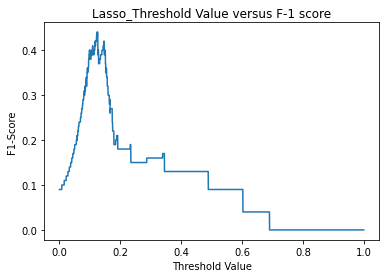

In [19]:
scores_lasso,f1score_lasso,alpha_lasso,tol_lasso=lasso_model(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Lasso Regression Error Rate versus Alpha')

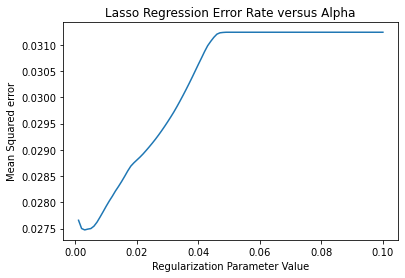

In [20]:
plt.plot(np.linspace(0.001,0.1,100),np.abs(scores_lasso))
plt.xlabel('Regularization Parameter Value')
plt.ylabel('Mean Squared error')
plt.title('Lasso Regression Error Rate versus Alpha')

In [21]:
np.linspace(0,1,10001)

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01,
       1.000e+00])

In [22]:
print('Alpha',alpha_lasso)
print('Tol',tol_lasso)

Alpha 0.003
Tol 0.12240000000000001


In [23]:
for i in range(100):
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2,stratify=y,random_state=i)
    clf_lasso=Lasso(alpha=alpha_lasso).fit(X_train,y_train)
    Z_lasso=threshold(clf_lasso.predict(X_test),tol_lasso)
    f1score_1=[]
    f1score_1.append(f1_score(y_test,Z_lasso))

In [24]:
print('Average F1 Score=',np.mean(f1score_1))
evaluation(y_test,Z_lasso)
metrics.confusion_matrix(y_test,Z_lasso)

Average F1 Score= 0.4772727272727273
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1320
         1.0       0.48      0.48      0.48        44

    accuracy                           0.97      1364
   macro avg       0.73      0.73      0.73      1364
weighted avg       0.97      0.97      0.97      1364

-----------------------------------------------------


array([[1297,   23],
       [  23,   21]], dtype=int64)

In [25]:
idx=np.abs(np.round(clf_lasso.coef_,2))>0
selected_feature=var[idx]
print('Selected Features=',selected_feature)
print('Feature Value=',clf_lasso.coef_[idx])

Selected Features= [' ROA(C) before interest and depreciation before interest'
 ' Debt ratio %' ' Borrowing dependency' ' Total Asset Turnover'
 ' Cash/Current Liability' ' Total expense/Assets'
 ' Fixed Assets to Assets' ' Liability-Assets Flag']
Feature Value= [-0.02446671  0.02241025  0.02416127 -0.0072779   0.00705553  0.01146281
  0.00784589  0.01683052]


In [26]:
Z_L=threshold(clf_lasso.predict(X),tol_lasso)
evaluation(y,Z_L)
metrics.confusion_matrix(y,Z_L)

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      6599
         1.0       0.36      0.46      0.41       220

    accuracy                           0.96      6819
   macro avg       0.67      0.72      0.69      6819
weighted avg       0.96      0.96      0.96      6819

-----------------------------------------------------


array([[6419,  180],
       [ 118,  102]], dtype=int64)

### Ridge Analysis

In [29]:
from sklearn.linear_model import Ridge
def ridge_model(X_train, X_test, y_train, y_test):
    alphas=np.linspace(2000,3000,100)
    cv=KFold(n_splits=10,shuffle=True,random_state=123)
    scores=[cross_val_score(Ridge(alpha=k),X,y,cv=cv,scoring='neg_mean_squared_error').mean() for k in alphas]
    f1score=[]
    for i in range(10000):
        clf=Ridge(alpha=alphas[np.argmin(np.abs(scores))]).fit(X_train,y_train)
        Z_Ridge=threshold(clf.predict(X_test),i*0.0001)
        k=round(f1_score(y_test,Z_Ridge),2)
        f1score.append(k)
    plt.plot(np.linspace(0,1,10000),f1score)
    plt.xlabel('Threshold Value')
    plt.ylabel('F1-Score')
    plt.title('Ridge_Threshold Value versus F-1 score')
    
    tol=np.argmax(f1score)*0.0001
    return scores,f1score,alphas[np.argmin(np.abs(scores))],tol

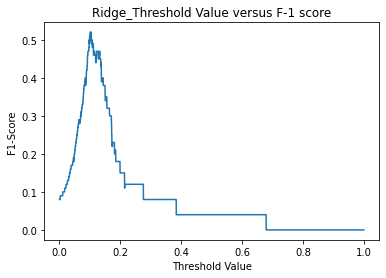

In [30]:
scores_ridge,f1score_ridge,alpha_ridge,tol_ridge=ridge_model(X_train, X_test, y_train, y_test)

Text(0.5, 1.0, 'Ridge Regression Error Rate versus Alpha')

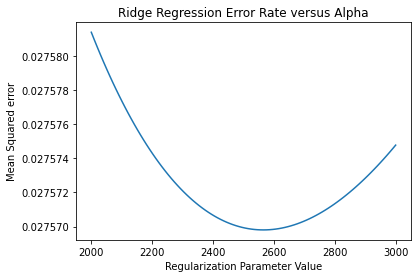

In [31]:
plt.plot(np.linspace(2000,3000,100),np.abs(scores_ridge))
plt.xlabel('Regularization Parameter Value')
plt.ylabel('Mean Squared error')
plt.title('Ridge Regression Error Rate versus Alpha')

In [32]:
print('Alpha',alpha_ridge)
print('Tol',tol_ridge)

Alpha 2565.6565656565654
Tol 0.10110000000000001


In [33]:
for i in range(100):
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2,stratify=y,random_state=i)
    clf_ridge=Ridge(alpha=alpha_ridge).fit(X_train,y_train)
    Z_Ridge=threshold(clf_ridge.predict(X_test),tol_ridge)
    f1score_2=[]
    f1score_2.append(f1_score(y_test,Z_Ridge))
print('Average F1 Score=',np.mean(f1score_2))
evaluation(y_test,Z_Ridge)
metrics.confusion_matrix(y_test,Z_Ridge)

Average F1 Score= 0.5172413793103449
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1320
         1.0       0.42      0.68      0.52        44

    accuracy                           0.96      1364
   macro avg       0.70      0.82      0.75      1364
weighted avg       0.97      0.96      0.96      1364

-----------------------------------------------------


array([[1278,   42],
       [  14,   30]], dtype=int64)

In [34]:
Z_R=threshold(clf_ridge.predict(X),tol_ridge)
evaluation(y,Z_R)
metrics.confusion_matrix(y,Z_R)

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      6599
         1.0       0.30      0.61      0.41       220

    accuracy                           0.94      6819
   macro avg       0.65      0.78      0.69      6819
weighted avg       0.96      0.94      0.95      6819

-----------------------------------------------------


array([[6290,  309],
       [  85,  135]], dtype=int64)

### Elastic Net

In [35]:
from sklearn.linear_model import ElasticNet
def ElasticNet_model(X_train, X_test, y_train, y_test):
    alphas=np.linspace(0.001,0.1,100)
    cv=KFold(n_splits=10,shuffle=True,random_state=123)
    scores=[cross_val_score(ElasticNet(alpha=k),X,y,cv=cv,scoring='neg_mean_squared_error').mean() for k in alphas]
    f1score=[]
    for i in range(10000):
        clf=ElasticNet(alpha=alphas[np.argmin(np.abs(scores))]).fit(X_train,y_train)
        Z_ElasticNet=threshold(clf.predict(X_test),i*0.0001)
        k=round(f1_score(y_test,Z_ElasticNet),2)
        f1score.append(k)
    plt.plot(np.linspace(0,1,10000),f1score)
    plt.xlabel('Threshold Value')
    plt.ylabel('F1-Score')
    plt.title('Elastic Net_Threshold Value versus F-1 score')
    tol=np.argmax(f1score)*0.0001
    return scores,f1score,alphas[np.argmin(np.abs(scores))],tol

Average F1 Score= 0.5555555555555556
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1320
         1.0       0.47      0.68      0.56        44

    accuracy                           0.96      1364
   macro avg       0.73      0.83      0.77      1364
weighted avg       0.97      0.96      0.97      1364

-----------------------------------------------------


array([[1286,   34],
       [  14,   30]], dtype=int64)

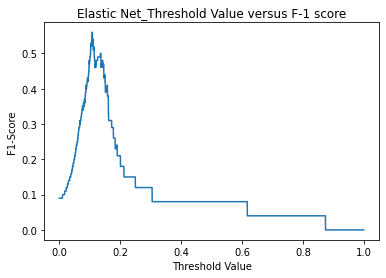

In [36]:
scores_EN,f1score_EN,alpha_EN,tol_EN=ElasticNet_model(X_train, X_test, y_train, y_test)
for i in range(100):
    X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2,stratify=y,random_state=i)
    clf_EN=ElasticNet(alpha=alpha_EN).fit(X_train,y_train)
    Z_ElasticNet=threshold(clf_EN.predict(X_test),tol_EN)
    f1score_3=[]
    f1score_3.append(f1_score(y_test,Z_ElasticNet))
print('Average F1 Score=',np.mean(f1score_3))
evaluation(y_test,Z_ElasticNet)
metrics.confusion_matrix(y_test,Z_ElasticNet)

Text(0.5, 1.0, 'Ridge Regression Error Rate versus Alpha')

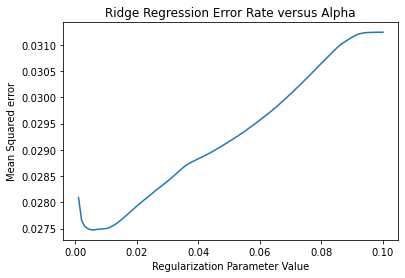

In [37]:
plt.plot(np.linspace(0.001,0.1,100),np.abs(scores_EN))
plt.xlabel('Regularization Parameter Value')
plt.ylabel('Mean Squared error')
plt.title('Ridge Regression Error Rate versus Alpha')

In [38]:
print('Alpha',alpha_EN)
print('Tol',tol_EN)

Alpha 0.006
Tol 0.1075


In [39]:
idx_EN=np.abs(np.round(clf_EN.coef_,2))>0
selected_feature=var[idx_EN]
print('Selected Features=',selected_feature)
print('Feature Value=',clf_EN.coef_[idx_EN])
print('Intercept=',clf_EN.intercept_)

Selected Features= [' ROA(C) before interest and depreciation before interest'
 ' Debt ratio %' ' Borrowing dependency' ' Total Asset Turnover'
 ' Cash/Current Liability' ' Total expense/Assets'
 ' Fixed Assets to Assets' ' Liability-Assets Flag']
Feature Value= [-0.02441182  0.0223063   0.02408567 -0.00723266  0.0070422   0.01146069
  0.00783226  0.01675808]
Intercept= 0.03147494329278679


In [40]:
Z_EN=threshold(clf_EN.predict(X),tol_EN)
evaluation(y,Z_EN)
metrics.confusion_matrix(y,Z_EN)

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      6599
         1.0       0.32      0.60      0.42       220

    accuracy                           0.95      6819
   macro avg       0.65      0.78      0.70      6819
weighted avg       0.96      0.95      0.95      6819

-----------------------------------------------------


array([[6322,  277],
       [  88,  132]], dtype=int64)

In [41]:
variable_EN=pd.DataFrame(data=[0])
V=clf_EN.coef_[clf_EN.coef_!=0]
for name,value in zip(var,V):
    variable_EN[name]=value
del variable_EN[0]

In [42]:
display(variable_EN)

,ROA(C) before interest and depreciation before interest,Operating Gross Margin,Operating Profit Rate,Non-industry income and expenditure/revenue,Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),...,Revenue Per Share (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio
0,-0.024412,-0.001269,0.002604,-0.004748,-0.000218,0.022306,0.024086,-0.007233,-0.001842,0.00347,...,-0.001632,-0.001341,0.007042,0.000308,0.011461,-0.001993,0.007832,0.002581,0.016758,0.000921


In [48]:
variable_EN.to_csv('export.csv')